## Table of Contents
* [Introduction](#Introduction)
* [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    * [Image Distribution](#Image-Distribution)
    * [Image Count](#Image-Count)
    * [Class Visualization](#Class-Visualization)
* [Image Preprocessing](#Image-Preprocessing)
     * [Image Resize](#Image-Resize)
     * [Datasets](#Datasets)
* [Model](#Model)
     * [Data Augmentation](#Data-Augmentation)
     * [Callbacks](#Callbacks)
     * [Base Model](#Base-Model)
     * [Base Model Performance](#Base-Model-Performance)
     * [Fine-Tuned Model](#Fine-Tuned-Model)
     * [Fine-Tuned Model Performance](#Fine-Tuned-Model-Performance)
* [Evaluation](#Evaluation)
     * [Accuracy](#Accuracy)
     * [Precision, Recall & F1](#Precision-Recall-F1)
     * [Confusion Matrix](#Confusion-Matrix)

## Introduction

Tom and Jerry are icons of childhood entertainment, bringing joy and laughter to generations of fans through their clever antics and timeless rivalry. In this project, we seek to utilize the latest advances in deep learning to enable a model to detect the presence of these beloved characters in a dataset of over 5,000 images extracted from various episodes of the show. It is our hope that through this exploration, we can not only demonstrate the capabilities of machine learning, but also pay tribute to the enduring charm of Tom and Jerry.

In [1]:
# Importing required libraries
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import random
import pandas as pd
import splitfolders
import cv2
import glob
import csv
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing
import squarify
import seaborn as sns
from sklearn.metrics import classification_report
from tensorflow.keras import mixed_precision

In [2]:
# Setting plot style
plt.style.use('ggplot')

In [3]:
# Splitting dataset into train, validation, and test sets
splitfolders.ratio("Data/Raw Dataset",
                   output = "Data/Preprocessed Dataset",
                   seed = 42, 
                   ratio = (.7, .2, .1),
                   group_prefix = None,
                   move = False)

## Exploratory Data Analysis

### Image Distribution

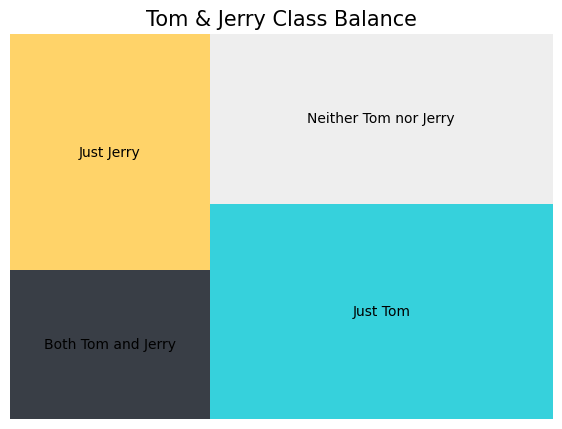

In [4]:
# The directory where raw dataset is located
raw_images_dir = 'Data/Raw Dataset'

# All the class names in the correct order
class_names = ['Both Tom and Jerry', 'Just Jerry', 'Just Tom', 'Neither Tom nor Jerry']

# Get the number of images for each class
image_counts = [len(os.listdir(os.path.join(raw_images_dir, class_name))) for class_name in class_names]

# Create a squarify plot of the class distribution
fig, ax = plt.subplots(figsize = (7, 5))

colors = ['#393E46', '#FFD369', '#36D1DC', '#EEEEEE']

squarify.plot(image_counts, label = class_names, ax = ax, color = colors, text_kwargs = {"fontsize": 10})

plt.title("Tom & Jerry Class Balance", fontsize = 15)
plt.axis("off");

### Image Count

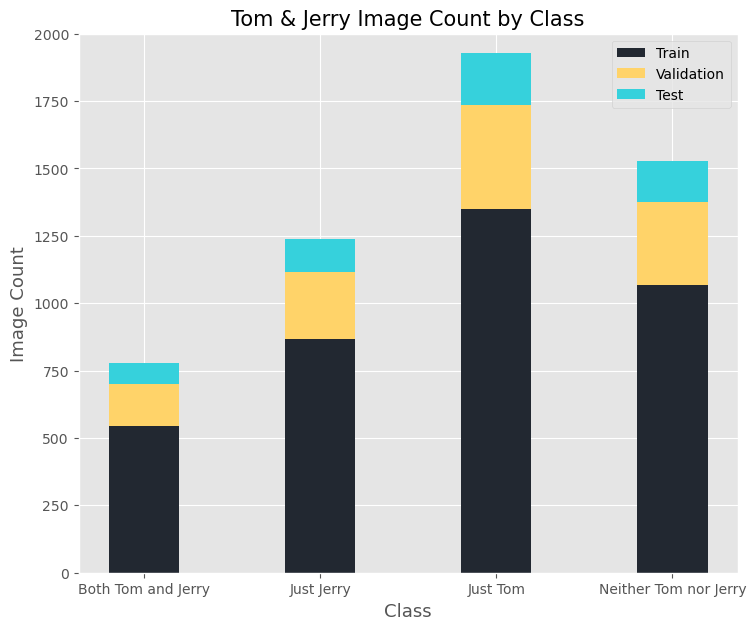

In [5]:
# The directory where preprocessed dataset is located
pre_images_dir = 'Data/Preprocessed Dataset'

# Calculate the number of images in each class for train, validation, and test sets
train_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "train", class_name))) for class_name in class_names]
val_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "val", class_name))) for class_name in class_names]
test_image_counts = [len(os.listdir(os.path.join(pre_images_dir, "test", class_name))) for class_name in class_names]

# Convert the image count lists to numpy arrays
train_image_counts = np.array(train_image_counts)
val_image_counts = np.array(val_image_counts)
test_image_counts = np.array(test_image_counts)

# Create a bar plot of image counts for each class in each dataset split
fig, ax = plt.subplots(figsize = (8.5, 7))

ax.bar(class_names, train_image_counts, width = 0.4, label = "Train", color = "#222831")
ax.bar(class_names, val_image_counts, width = 0.4, label = "Validation", bottom = train_image_counts, color = "#FFD369")
ax.bar(class_names, test_image_counts, width = 0.4, label = "Test", bottom = train_image_counts + val_image_counts, color="#36D1DC")

# Set the y-axis limit and add labels for the x and y axes
ax.set_ylim(0, 2000)
plt.ylabel("Image Count", fontsize = 13)
plt.xlabel("Class", fontsize = 13)
plt.title("Tom & Jerry Image Count by Class", fontsize = 15)
ax.legend();

### Class Visualization

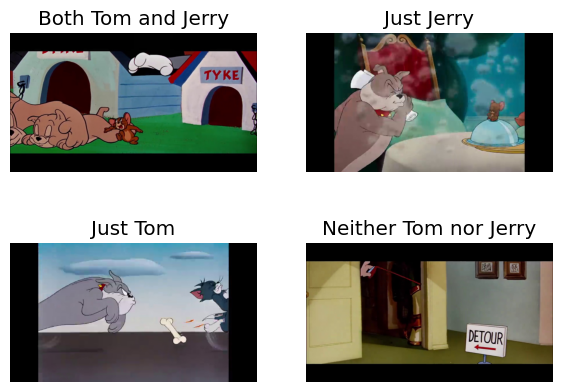

In [6]:
# Images are loaded from the Raw Dataset directory
images = []

# Loop through all class names and pick a random image for each class
for class_name in class_names:
    image_files = os.listdir(os.path.join(raw_images_dir, class_name))
    image_file = random.choice(image_files)
    images.append(os.path.join(raw_images_dir, class_name, image_file))

# Loop through all the images and display them in the subplot
fig, ax = plt.subplots(2, 2, figsize = (7, 5))

for i in range(4):
    ax[i // 2, i % 2].imshow(plt.imread(images[i]))
    ax[i // 2, i % 2].set(title = class_names[i])
    ax[i//2, i%2].axis('off')

## Image Preprocessing

### Image Resize

In [7]:
# Get a list of directories (train, val, test) in preprocessed dataset
main_directories = os.listdir(pre_images_dir)

# Loop through each main directory and get a list of sub-directories (class folders) in it
for main_directory in main_directories:
    main_directory_path = os.path.join(pre_images_dir, main_directory)
    sub_directories = os.listdir(main_directory_path)
    
    # Loop through each sub-directory (class) and get a list of all image paths
    for sub_directory in sub_directories:
        sub_directory_path = os.path.join(main_directory_path, sub_directory)
        image_paths = glob.glob(os.path.join(sub_directory_path, '*'))
        
        # Loop through each image path and resize it
        for image_path in image_paths:
            img = cv2.imread(image_path)
            img = cv2.resize(img, (224, 224), interpolation = cv2.INTER_CUBIC)
            img = img.astype(np.float32)
            cv2.imwrite(image_path, img)

### Datasets

In [8]:
# Load the training dataset
train_data = tf.keras.preprocessing.image_dataset_from_directory('Data/Preprocessed Dataset/train', 
                                                                 label_mode = "categorical",
                                                                 image_size = (224, 224) ,
                                                                 seed = 42) 

Found 3834 files belonging to 4 classes.


In [9]:
# Load the validation dataset
val_data = tf.keras.preprocessing.image_dataset_from_directory('Data/Preprocessed Dataset/val',
                                                                label_mode = "categorical",
                                                                image_size = (224, 224),
                                                                seed = 42)

Found 1095 files belonging to 4 classes.


In [10]:
# Load the test dataset
test_data = tf.keras.preprocessing.image_dataset_from_directory('Data/Preprocessed Dataset/test',
                                                                label_mode = "categorical",
                                                                image_size = (224, 224),
                                                                seed = 42,
                                                                shuffle = False) 

Found 549 files belonging to 4 classes.


## Model

### Data Augmentation

In [11]:
# Data Augmentation layer
data_augmentation = Sequential([
  preprocessing.RandomFlip('horizontal', seed = 42),
  preprocessing.RandomRotation(0.2, seed = 42), 
  preprocessing.RandomHeight(0.2, seed = 42), 
  preprocessing.RandomWidth(0.2, seed = 42),
  preprocessing.RandomZoom(0.2, seed = 42)])

### Callbacks

In [12]:
# Callback to save the best model based on validation accuracy during training
model_checkpoint = tf.keras.callbacks.ModelCheckpoint('Data/Checkpoint',
                                                      save_best_only = True,
                                                      monitor = "val_accuracy")

# Callback to reduce the learning rate when the validation accuracy stops improving
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_accuracy",  
                                                 factor = 0.2,
                                                 patience = 2,
                                                 min_lr = 1e-7)

# Callback to log training history to a csv file
base_csv_logger = tf.keras.callbacks.CSVLogger('Data/Base Model History.csv')
ft_csv_logger = tf.keras.callbacks.CSVLogger('Data/Fine-Tuned Model History.csv')

### Base Model

In [13]:
# Set the global mixed precision policy to "mixed_float16"
mixed_precision.set_global_policy(policy="mixed_float16")

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [14]:
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False) # Load the EfficientNetV2B0 model without the top layer
base_model.trainable = False # Freeze the base model layers to prevent backpropagation through them

inputs = layers.Input(shape = (224, 224, 3)) # Input layer

x = data_augmentation(inputs) # Apply data augmentation to the image

x = base_model(inputs, training = False) # Pass the image through the base model
x = layers.Dropout(.2)(x) # Apply dropout to prevent overfitting

x = layers.GlobalAveragePooling2D()(x) # Perform global average pooling to reduce the spatial dimensions
x = layers.Dropout(.3)(x)

x = layers.Dense(4)(x) # Output layer
outputs = layers.Activation("softmax", dtype = tf.float32)(x) 

# Create the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ["accuracy"])

In [15]:
# Model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, None, None, 1280)  5919312  
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124  

In [ ]:
# Training the base model
model.fit(train_data, 
          epochs = 20,
          steps_per_epoch = len(train_data),
          validation_data = val_data,
          validation_steps = len(val_data),
          callbacks = [model_checkpoint, reduce_lr, base_csv_logger])

### Base Model Performance

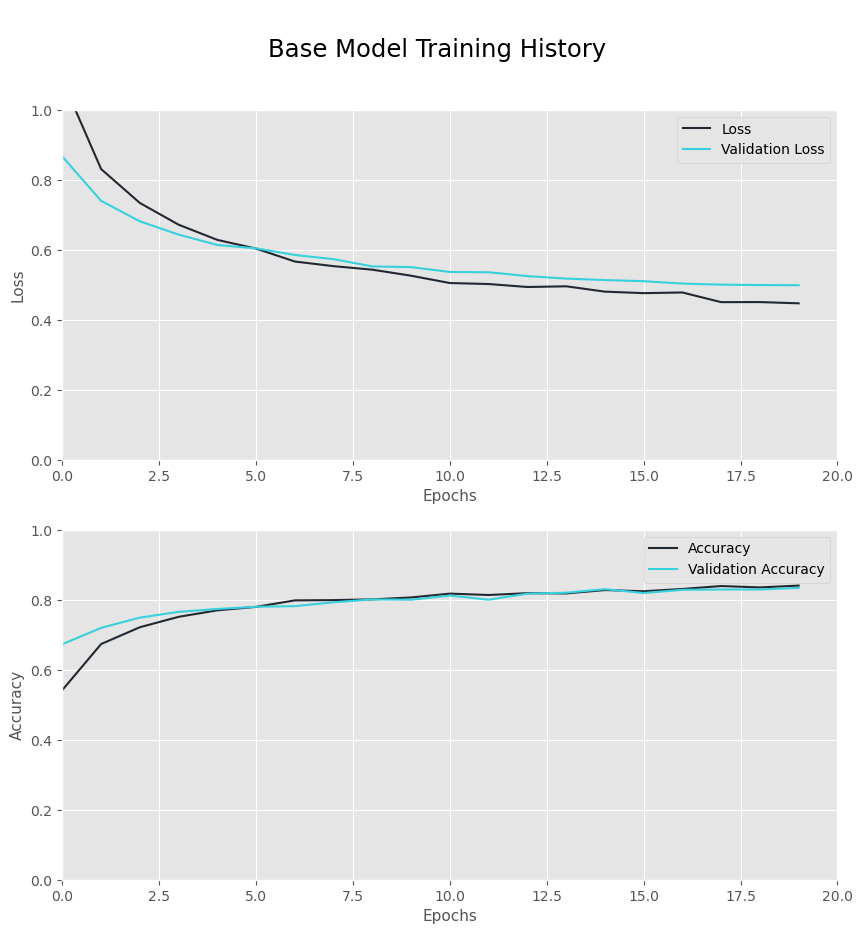

In [16]:
# Load the base model's training history
history = pd.read_csv('Data/Base Model History.csv')

# Extract the values for loss, val_loss, accuracy, and val_accuracy
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Define number of epochs
epochs = range(len(loss))

# Plot the training history using two subplots (for loss and accuracy)        
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

fig.suptitle("\nBase Model Training History", fontsize = 17.5)

ax[0].plot(epochs, loss, label = 'Loss', color = "#222831")
ax[0].plot(epochs, val_loss, label = 'Validation Loss', color = "#36D1DC")
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Epochs', fontsize = 11)
ax[0].set_ylabel('Loss', fontsize = 11)
ax[0].legend()

ax[1].plot(epochs, accuracy, label = 'Accuracy', color = "#222831")
ax[1].plot(epochs, val_accuracy, label = 'Validation Accuracy', color = "#36D1DC")
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs', fontsize = 11)
ax[1].set_ylabel('Accuracy', fontsize = 11)
ax[1].legend();

### Fine Tuned Model

In [17]:
# Unfreezing the base model's layers entirely
base_model.trainable = True

# Compiling the model
model.compile(loss = "categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate = 4.0000e-06),
              metrics = ["accuracy"])

In [ ]:
# Training the fine-tuned model
history = model.fit(train_data, 
                    epochs = 20,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = len(val_data),
                    callbacks = [model_checkpoint, reduce_lr, ft_csv_logger])

### Fine Tuned Model Performance

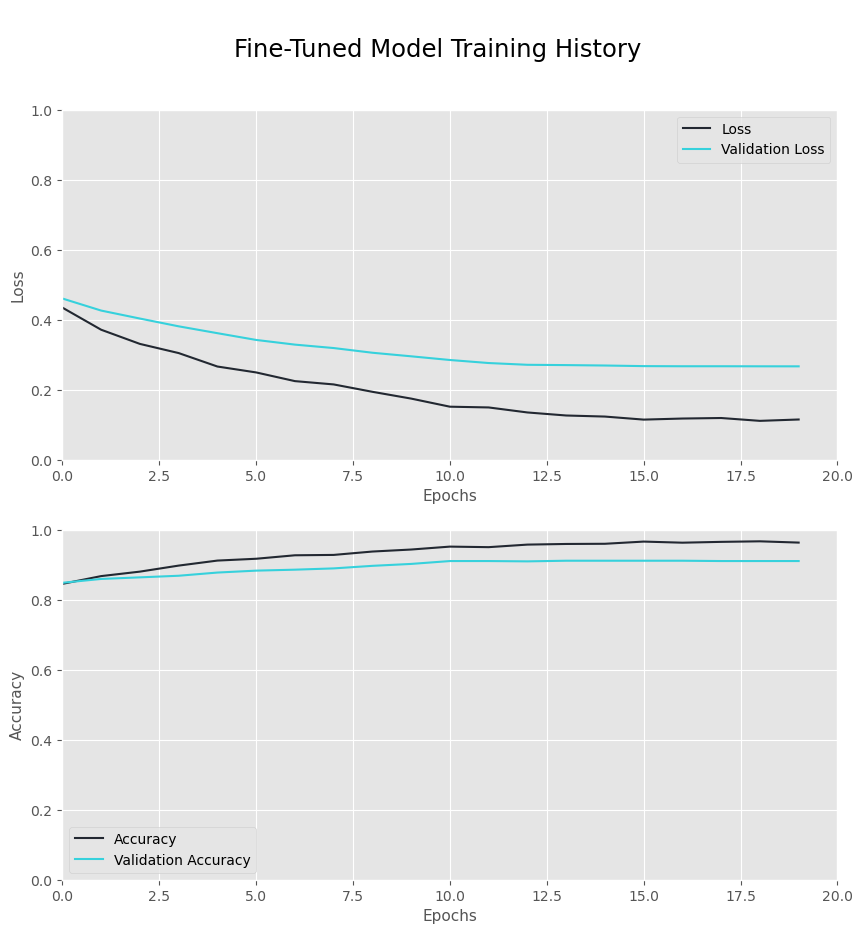

In [18]:
# Load the fine-tuned model's training history
history = pd.read_csv('Data/Fine-Tuned Model History.csv')

# Extract the values for loss, val_loss, accuracy, and val_accuracy
loss = history['loss']
val_loss = history['val_loss']
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']

# Define number of epochs
epochs = range(len(loss))

# Plot the training history using two subplots (for loss and accuracy)        
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

fig.suptitle("\nFine-Tuned Model Training History", fontsize = 17.5)

ax[0].plot(epochs, loss, label = 'Loss', color = "#222831")
ax[0].plot(epochs, val_loss, label = 'Validation Loss', color = "#36D1DC")
ax[0].set_xlim(0, 20)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Epochs', fontsize = 11)
ax[0].set_ylabel('Loss', fontsize = 11)
ax[0].legend()

ax[1].plot(epochs, accuracy, label = 'Accuracy', color = "#222831")
ax[1].plot(epochs, val_accuracy, label = 'Validation Accuracy', color = "#36D1DC")
ax[1].set_xlim(0, 20)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs', fontsize = 11)
ax[1].set_ylabel('Accuracy', fontsize = 11)
ax[1].legend();

## Evaluation

In [ ]:
# Load the saved weights
model.load_weights('Data/Checkpoint')

### Accuracy

In [20]:
# Calculating the accuracy of the model on the test dataset
accuracy = model.evaluate(test_data)[1] * 100

18/18 [==============================] - 337s 19s/step - loss: 0.1939 - accuracy: 0.9344


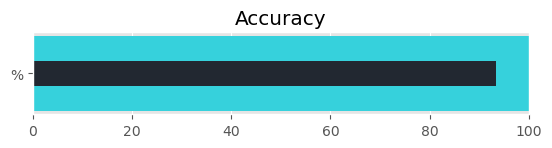

In [21]:
# Plot a horizontal bar plot to represent accuracy
fig, ax = plt.subplots()

ax.barh([1], 100, left = 0, height = 15, color = "#36D1DC")
ax.barh([1], accuracy, height = 5, color="#222831");

ax.set_aspect('equal')
ax.set_yticks([1])
ax.set_yticklabels('%')
ax.set_xlim(0, 100)
ax.set(title = 'Accuracy');

### Precision-Recall-F1

In [22]:
# Predictions the test data
test_pred = model.predict(test_data)

# Getting the highest probabilty prediction
test_pred = np.argmax(test_pred, axis = 1)

# Creating an empty list to store the true labels
test_true = []

for images, labels in test_data.unbatch():
  test_true.append(labels.numpy().argmax()) 

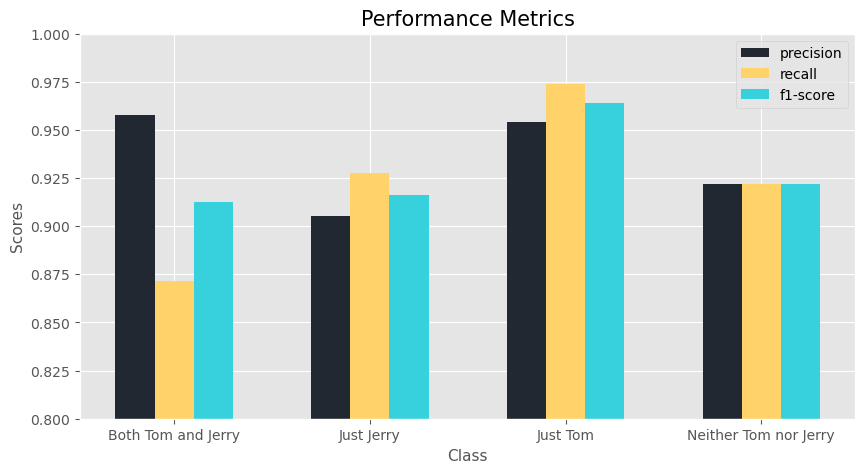

In [23]:
# Calculate the classification report
report = classification_report(test_true, test_pred, output_dict = True)

# Define the metrics to use
metrics = ["precision", "recall", "f1-score"]

# Initialize a list to store the scores for each class
class_scores = []
for i in range(4):
    class_scores.append([report[str(i)][metric] for metric in metrics])

# Plot the data 
fig, ax = plt.subplots(figsize = (10, 5))

bar_width = 0.2
for i, scores in enumerate(class_scores):
    ax.bar(i - bar_width, scores[0], bar_width, color = "#222831")
    ax.bar(i, scores[1], bar_width, color = "#FFD369")
    ax.bar(i + bar_width, scores[2], bar_width, color = "#36D1DC")

ax.set_xlabel("Class", fontsize = 11)
ax.set_ylabel("Scores", fontsize = 11)
ax.set_ylim(0.80, 1)
ax.legend(metrics)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels(class_names)
ax.set_title("Performance Metrics", fontsize = 15);

### Confusion Matrix

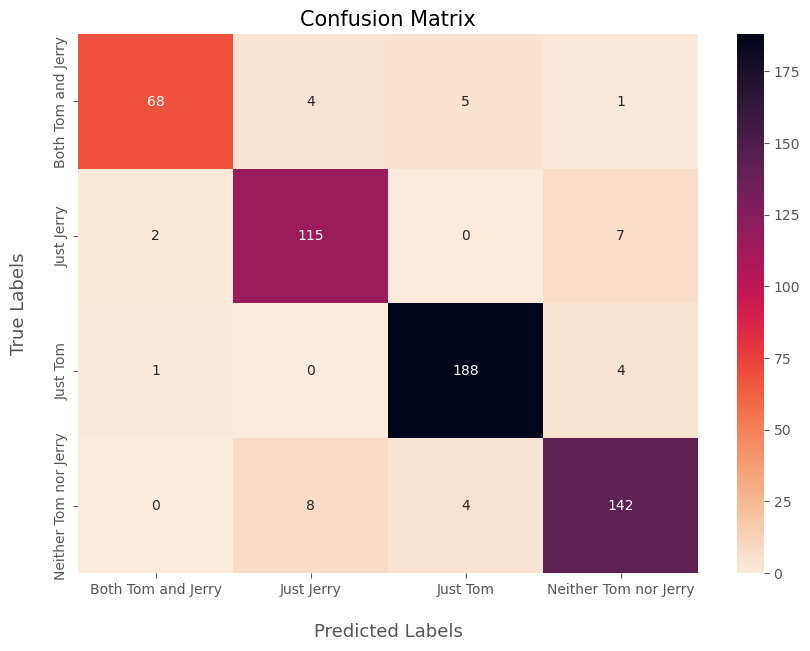

In [24]:
# Calculate the confusion matrix
cm = tf.math.confusion_matrix(test_true, test_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize = (10, 7))

sns.heatmap(cm, 
            annot = True, 
            fmt= '', 
            ax = ax, 
            cmap = 'rocket_r')

ax.set_yticklabels(class_names, va="center")
ax.set_xticklabels(class_names, ha="center")
ax.set_xlabel('\nPredicted Labels', fontsize = 13)
ax.set_ylabel('True Labels\n', fontsize = 13)

plt.title("Confusion Matrix", fontsize = 15);